# Projeto 1 - Prevendo Complicações de Infarto do Miocárdio

Universidade de Brasília

Departamento de Ciência da Computação

Projeto 1, Fundamentos de Sistemas Inteligentes, Turma A, 2022/2

Prof. Díbio

## Introdução

O presente projeto tem como objetivo utilizar modelos de classificação supervisionados para prever complicações de infarto do miocárdio com base nas informações sobre um paciente no momento da admissão e no terceiro dia de internação. É utilizado o dataset disponível em https://archive.ics.uci.edu/ml/datasets/Myocardial+infarction+complications.

### Importação de bibliotecas

In [1]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from numpy import mean

import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", message='Variables are collinear')  # Usado para ocultar o warning emitido pelo QDA

### Análise do dataset

Primeiramente, o dataset é lido do arquivo .csv. Pelo atributo shape podemos ver que o dataset tem 1700 linhas e 124 atributos. São mostradas 10 amostras aleatórias do dataset para se ter uma visão geral dele.

In [2]:
df = pd.read_csv('data.csv')

print('Shape:', df.shape)

df.sample(10)

Shape: (1700, 124)


,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,...,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
1217,1218,43.0,1,0.0,0.0,0.0,0.0,NaN,2.0,0.0,...,0,0,0,0,0,0,1,0,1,0
421,422,65.0,1,0.0,3.0,2.0,2.0,NaN,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1602,1603,84.0,0,0.0,0.0,0.0,0.0,NaN,2.0,0.0,...,0,0,0,0,1,0,0,0,0,3
512,513,68.0,1,2.0,6.0,2.0,2.0,NaN,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1131,1132,72.0,0,3.0,6.0,3.0,1.0,NaN,2.0,0.0,...,0,0,0,1,0,0,1,0,0,0
1447,1448,76.0,1,0.0,6.0,3.0,2.0,NaN,3.0,0.0,...,0,0,0,1,0,0,0,0,0,1
507,508,75.0,1,1.0,5.0,2.0,2.0,NaN,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1170,1171,54.0,1,0.0,0.0,0.0,0.0,NaN,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
245,246,45.0,1,0.0,0.0,0.0,0.0,NaN,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1354,1355,64.0,0,0.0,1.0,2.0,2.0,NaN,2.0,0.0,...,0,0,0,1,0,0,0,0,0,0


Aqui pode-se ver que o dataset tem muitos valores faltantes (chamados de NA), com colunas chegando a ter 1696 (99% das linhas) de linhas sem valor.

In [3]:
df.isna().sum().sort_values(ascending=False).head(10)

KFK_BLOOD     1696
IBS_NASL      1628
S_AD_KBRIG    1076
D_AD_KBRIG    1076
NOT_NA_KB      686
LID_KB         677
NA_KB          657
GIPER_NA       375
NA_BLOOD       375
K_BLOOD        371
dtype: int64

### Limpeza e separação

É preciso então tratar essa falta de valores. Primeiramente são removidas as colunas que tem menos de 1000 linhas preenchidas. Também são removidas as linhas que tem menos de 80% dos atributos. O restante dos valores faltantes são preenchidos utilizando interpolação linear, ou seja, são calculados com base nos valores dos outros atributos.

Serão analisados os classificadores em dois momentos: na admissão ao hospital e no terceiro dia de hospital. É necessário então separar o dataset em dois dataframes diferentes. O dataframe da admissão ao hospital contém todas as colunas de entrada (2-112) exceto 93, 94, 95, 100, 101, 102, 103, 104 e 105. O dataframe do terceiro dia de hospital contém todas as colunas de entrada (2-112). A coluna 1 não é utilizada em nenhum dos dataframes pois é a coluna com o identificador único de cada linha. As colunas 122 a 124 contém as possíveis complicações de infarto do miocárdio (output).

In [4]:
df.dropna(axis='columns', thresh=1000, inplace=True)
df.dropna(thresh=int(df.columns.size * 0.8), inplace=True)
df.drop(columns='ID', inplace=True)
df.interpolate(inplace=True)
df.dropna(inplace=True) # Alguns valores NaN não são preenchidos com interpolate

df_admission = df.drop(columns=['R_AB_1_n', 'R_AB_2_n', 'R_AB_3_n', 'NA_R_1_n', 'NA_R_2_n',
                                'NA_R_3_n', 'NOT_NA_1_n', 'NOT_NA_2_n', 'NOT_NA_3_n'])
df_third_day = df.copy()

Os dados são separados em 2 conjuntos (treinamento e teste), selecionados aleatoriamente em porções 70% e 30%, respectivamente. Cada conjunto tem seus dados de input (X) e output (y) separados.

In [5]:
X = df_admission.iloc[:, :-12]
y = df_admission.iloc[:, -12:]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=1)

### Classificação

É criada uma função que retorna as métricas de desempenho de um modelo passado como parâmetro. Esse é um problema de classificação com múltiplas saídas. Como os modelos só conseguem prever uma saída por vez, é feito a classificação e medição de desempenho para cada uma. Por fim, é feita a média das predições de todas as saídas.

In [6]:
def get_model_report(model):
    accuracies = []
    precisions = []
    recalls = []
    f1s = []

    for i in range(-12, 0):
        model.fit(X_train, y_train.iloc[:, i])
        predictions = model.predict(X_test)

        correct_output = y_test.iloc[:, i]
        accuracy = accuracy_score(correct_output, predictions)
        precision = precision_score(
            correct_output, predictions, average='weighted', zero_division=0)
        recall = recall_score(correct_output, predictions,
                              average='weighted', zero_division=0)
        f1 = f1_score(correct_output, predictions,
                      average='weighted', zero_division=0)

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    return {'accuracy': round(mean(accuracies), 4),
            'precision': round(mean(precisions), 4),
            'recall': round(mean(recalls), 4),
            'f1_weighted': round(mean(f1s), 4)}

São testados quatro modelos de classificação: LDA, QDA, CART e KNN. Todos com suas configurações padrões. Os dados de acurácia, precisão, revocação e medida F1 de cada modelo são mostrados na tabela, ordenados pela acurácia. 

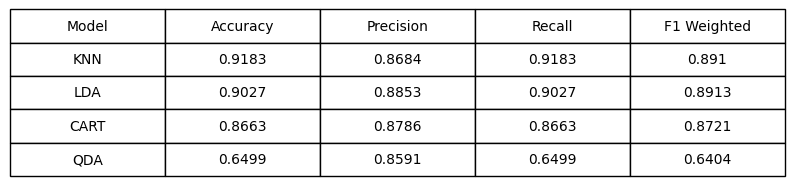

In [7]:
def compare_models(models):
    rows = []
    for name, model in models:
        report = get_model_report(model)
        rows.append([name, *report.values()])

    rows.sort(key=lambda row: row[1], reverse=True)
    colLabels = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Weighted']
    plt.figure(figsize=(10, 2))
    plt.axis('off')
    table = plt.table(cellText=rows, colLabels=colLabels,
                      loc='center', cellLoc='center')
    table.scale(1, 2)


models = [('LDA', LinearDiscriminantAnalysis()),
          ('QDA', QuadraticDiscriminantAnalysis()),
          ('CART', DecisionTreeClassifier()),
          ('KNN', KNeighborsClassifier())]

compare_models(models)

### Melhorando o desempenho

Para tentar melhorar o desempenho dos classificadores, serão verificados os melhores valores para 2 parâmetros: número de vizinhos no KNN e o número mínimo de amostras necessárias para dividir um nó interno no CART.

Para o modelo KNN, é verificada a acurácia para um k variando de 1 a 49. O melhor desempenho é alcançado com K = 20.

Max accuracy:  0.926 at K = 20


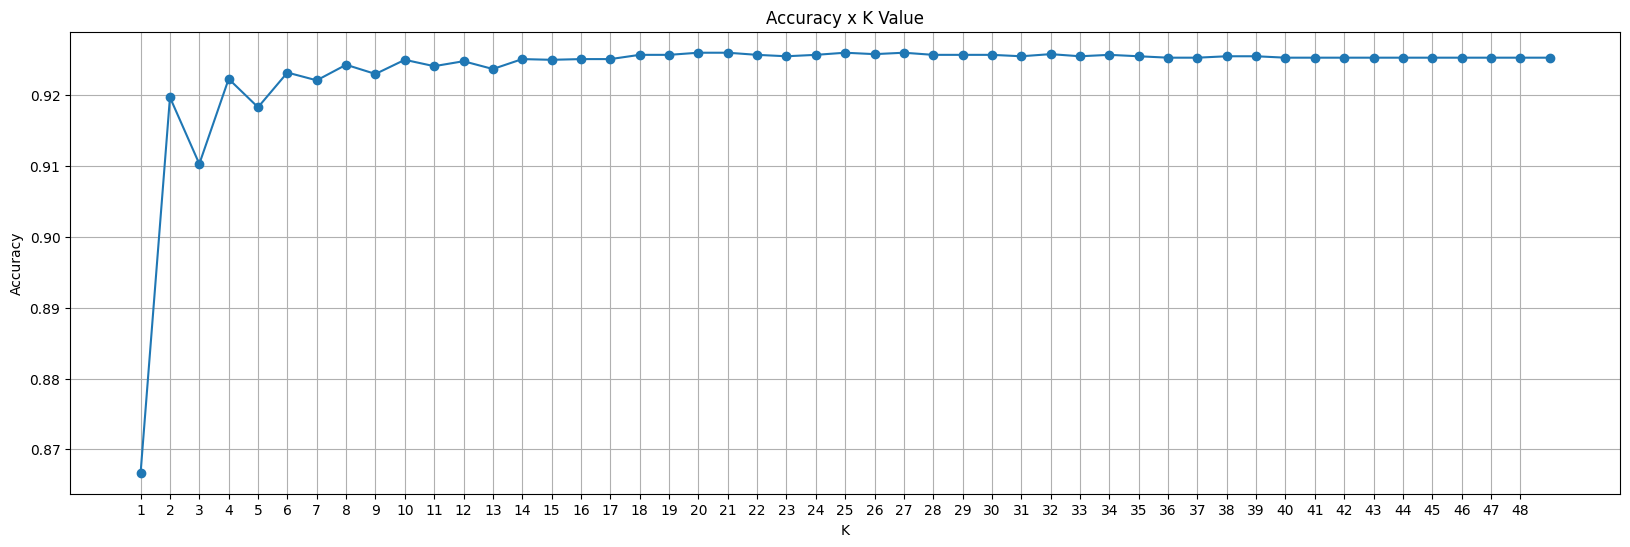

In [8]:
accuracies = []

ks = list(range(1, 50))

for k in ks:
    report = get_model_report(KNeighborsClassifier(n_neighbors=k))
    accuracies.append(report['accuracy'])

plt.figure(figsize=(20, 6))
plt.plot(ks, accuracies, marker='o')
plt.title('Accuracy x K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(range(min(ks), max(ks)))
print("Max accuracy: ", max(accuracies),
      "at K =", ks[accuracies.index(max(accuracies))])

Para o modelo CART, é verificada a acurácia para o número mínimo de amostras necessárias para dividir um nó interno variando de 2 a 400. O melhor desempenho é alcançado com min_samples_split = 341 em que a acurácia é de 0.926, 6% maior que na configuração padrão.


Max accuracy:  0.926 at min_samples_split = 341


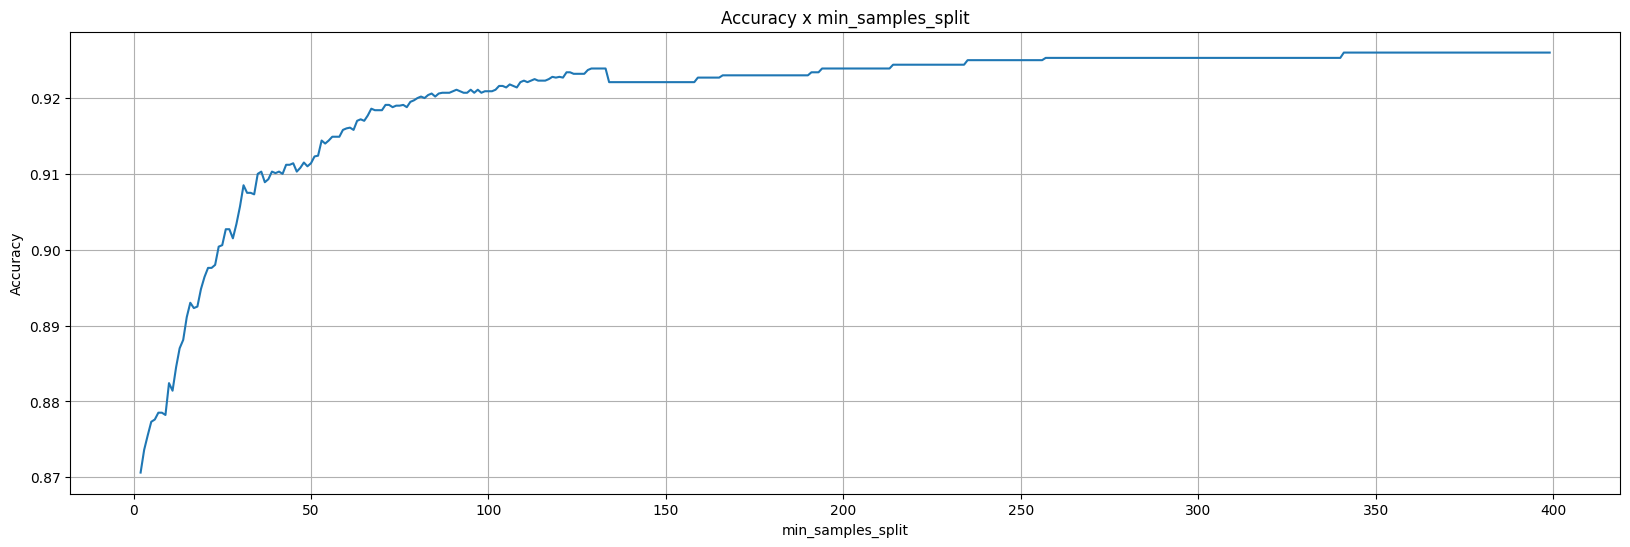

In [9]:
accuracies = []

possibles_min_samples_split = list(range(2, 400))

for min_samples_split in possibles_min_samples_split:
    report = get_model_report(DecisionTreeClassifier(
        min_samples_split=min_samples_split))
    accuracies.append(report['accuracy'])

plt.figure(figsize=(20, 6))
plt.plot(possibles_min_samples_split, accuracies)
plt.title('Accuracy x min_samples_split')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.grid(True)
print("Max accuracy: ", max(accuracies),
      "at min_samples_split =", possibles_min_samples_split[accuracies.index(max(accuracies))])

### Classificação final
Com os valores de parâmetros ajustados, é feita uma nova comparação entre modelos.

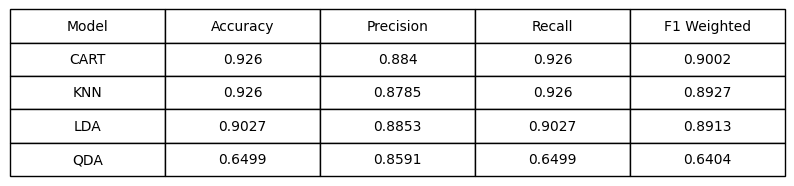

In [10]:
models = [('LDA', LinearDiscriminantAnalysis()),
          ('QDA', QuadraticDiscriminantAnalysis()),
          ('CART', DecisionTreeClassifier(min_samples_split=341)),
          ('KNN', KNeighborsClassifier(n_neighbors=20))]

compare_models(models)

É feita também a classificação para o dataframe do terceiro dia de internação.

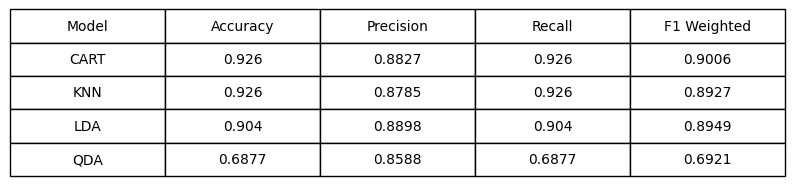

In [11]:
X = df_third_day.iloc[:, :-12]
y = df_third_day.iloc[:, -12:]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=1)

compare_models(models)

### Análise dos resultados

Os modelos CART e KNN obtiveram uma acurácia igual, mas a árvore de decisão obteve um melhor resultado em todas as outras medidas. O modelo se mostrou bastante eficaz atingindo 92% de acurácia, além de 90% de medida F, o que mostra que a acurácia obtida é confiável. O modelo também apresentou uma alta taxa de revocação, o que é positivo, pois é melhor prever que pacientes saudáveis vão ter complicações do que classificar pacientes doentes como saudáveis.